In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from arch.unitroot import ADF, ZivotAndrews
from statsmodels.tsa.stattools import zivot_andrews
from pmdarima import auto_arima

In [2]:
np.random.seed(42)

x = np.random.normal(0,1,1000)
y = np.random.normal(30,1,1000)
z = np.concatenate([x,y])

df = pd.DataFrame()
df["Data"] = z
df["Date"] = pd.date_range("01.01.2018", periods=len(z), freq="D")
df.set_index("Date", inplace=True)

df.head()

,Data
Date,
2018-01-01,0.496714
2018-01-02,-0.138264
2018-01-03,0.647689
2018-01-04,1.523030
2018-01-05,-0.234153


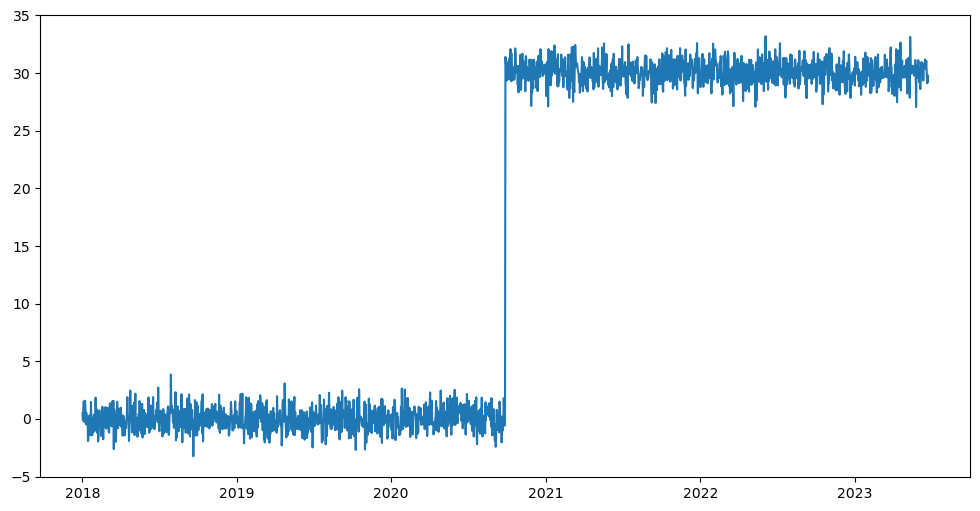

In [3]:
plt.figure(figsize=(12,6))
plt.plot(df)
plt.show()

In [4]:
ADF(df["Data"])

Test Statistic,-1.045
P-value,0.737
Lags,4


### According to the ADF test, the series is not stationary, but it is actually stationary. Due to structural breaks, the ADF test says that it is not stationary. We will try the ZivotAndrews test, which is suitable for structural breaks.

In [5]:
ZivotAndrews(df["Data"], trend="c")

Test Statistic,-44.122
P-value,0.000
Lags,4


### According to the ZivotAndrews test, the series is stationary.

In [6]:
zivot_andrews(df["Data"], regression="c") # index 999

(-44.12247810878753,
 1e-05,
 {'1%': -5.27644, '5%': -4.81067, '10%': -4.56618},
 4,
 999)

### Build a model with splitting

In [7]:
break_ = df.index[999] # it is the date for break
break_

Timestamp('2020-09-26 00:00:00')

In [8]:
before = df.loc[df.index <= break_]
after = df.loc[df.index > break_]

In [9]:
before

,Data
Date,
2018-01-01,0.000522
2018-01-02,-0.000145
2018-01-03,0.000680
2018-01-04,0.001600
2018-01-05,-0.000246
...,...
2020-09-22,-0.000295
2020-09-23,0.001888
2020-09-24,0.000673


In [10]:
after

,Data
Date,
2020-09-27,0.032984
2020-09-28,0.032486
2020-09-29,0.031577
2020-09-30,0.030835
2020-10-01,0.032248
...,...
2023-06-19,0.032638
2023-06-20,0.031486
2023-06-21,0.030588


In [11]:
model1 = auto_arima(df["Data"], trace=False, seasonal=False)
model2 = auto_arima(after["Data"], trace=False, seasonal=False)

print(model1.aic())
print(model2.aic())

-20424.276566685574
-10881.24463795091


### Build a model with dummy variables

In [12]:
df.loc[df.index <= break_, "Dummy"] = 0
df.loc[df.index > break_, "Dummy"] = 1

df

,Data,Dummy
Date,,
2018-01-01,0.000522,0.0
2018-01-02,-0.000145,0.0
2018-01-03,0.000680,0.0
2018-01-04,0.001600,0.0
2018-01-05,-0.000246,0.0
...,...,...
2023-06-19,0.032638,1.0
2023-06-20,0.031486,1.0
2023-06-21,0.030588,1.0


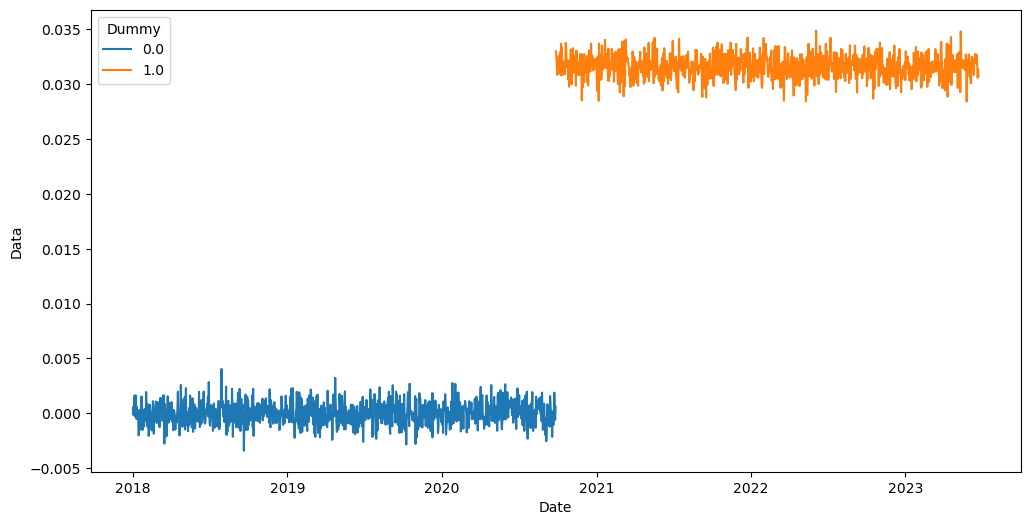

In [13]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df.index, y="Data", data=df, hue="Dummy")
plt.show()

In [14]:
X = df["Dummy"].values.reshape(-1,1)

model3 = auto_arima(df["Data"], trace=False, seasonal=False, X=X)

In [15]:
print(model1.aic())
print(model2.aic())
print(model3.aic())

-20424.276566685574
-10881.24463795091
-21802.558410940954
